



 # Week 8



 Rough notes.



 * Model checking  


 * Chapter 6 and Chapter 7 from BDA 3.



 * For chapter 6, Vehtari recommends skimming 6.4 and reading instead [Visualization in Bayesian workflow](https://ar5iv.labs.arxiv.org/html/1709.01449)



 * Also recommends reading [Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC](https://arxiv.org/abs/1507.04544) instead of 72 and 7.3




 * See brms_demo.Rmd for demos of some of this material using BRMS


### Primary tools

- Posterior predictive checking (PPC)
- Sensitivity analysis
    * Introduces also [*priorsense* ](https://n-kall.github.io/priorsense/) which is pretty cool, it uses a power-scaling on the prior and likelihood to make an estimate of the sensitivity of the posterior to the prior and the likelihood. In many cases you would expect the posterior to be more sensitive to the likelihood than the prior..   I note that Arviz apparently can also support this in the new version!  Note that this powerlaw scaling is done with importance sampling, not re-running the MCMC sampler, so it is fast.
    * Robust models are good for testing sensitivity to outliers.  (negative binomial, student t), based on the dispersion parameter.



 [Detecting and Diagnosing prior and likelihood sensitivity with power-scaling](https://link.springer.com/article/10.1007/s11222-023-10366-5)




## Cross validation

- EPLD is based on the `log score`  $\log p(y^{new} | y, M)$, which is the predicted log likelihood of 'new' data given the observed data and the model.

- Note that for Gaussian models, the EPLD is equivalent to the 'mean squared error' (MSE) of the model predictions. ALso called 'log likelihood' in frequentist statistics, and is commonly used to score models.

- In the limit of large sample sizes, the model with the lowest KL divergence from the true data generating process will have the highest EPLD, so this is reasonable to use as a measure of model fit.

$$
\text{KL}\left(p_{\text{true}} \,\|\, p(\cdot \mid \theta)\right) = \int p_{\text{true}}(y) \log \left( \frac{p_{\text{true}}(y)}{p(y \mid \theta)} \right) \, dy
$$

$$
\text{KL} = - \mathbb{E}_{p_{\text{true}}} \left[ \log p(y \mid \theta) \right]+ \int p_{\text{true}}(y) \log p_{\text{true}}(y) \, dy
$$


- Leave one out cross validation (LOO-CV) is a method for estimating EPLD without needing to sample new data. (k-fold could also be used, but there exist shortcuts for LOO-CV using importance sampling.)

$$
\text{epld\_loo} = \sum_{i=1}^{n} \log p(y_i | y_{-i}, M)
$$


- Both PYMC and Stan have functions for calculating LOO-CV  using PSIS but also can be run manually (takes a lot of time)

- Also mentioned LOO-PIT,  which does the 'probability integral transform' on left out data using the CDF of the rest of the data.  This should be uniform if the model is well calibrated.  

- See also roachescv.ipynb  for an example of using PYMC

## PSIS-LOO

- Lecture then discussed some of how PSIS-LOO works, enough to understand where it goes wrong. 

- Diagnostic: Pareto-k statistic. 
     - The 'smoothing' part of the importance sampling also provides a diagnostic.  
     - The smoothing fits the tails to a generalized Pareto distribution, and the Pareto-k statistic is the shape parameter of that distribution. 
     - if k > 0.7 then the importance sampling is not working well, and the LOO-CV estimate maybe unreliable. Might be able to just increase the number of samples.  
     - if k > 1.0 then this is a strong indication of issues and increasing samples will not help.
     - Otherwise consider k-fold cross validation.
     - In general high k values indicate that the importance sampling target distribution (posterior with one left out) is very different from the proposal distribution (full data posterior). Can be caused by:
            - model mis-specification
            - very flexible model (e.g. hierarchical model with one parameter per observation) ('moment matching' can help here)
    - More in the [CV-FAQ](https://users.aalto.fi/~ave/CV-FAQ.html)

## SOMETIMES cross validation is not needed

- Posterior predictive checking is often sufficient to check model fit.

- Cross validation is more useful for model comparison, next lesson!



 For my own notes, this useful book by Osvaldo [Exploratory Analysis of Bayesian Models](https://arviz-devs.github.io/EABM/)

 ## Exercise - 6.1

 Posterior predictive checking:



 (a) On page 120, the data from the SAT coaching experiments were checked against the

 model that assumed identical effects in all eight schools: the expected order statistics

 of the effect sizes were (26, 19, 14, 10, 6, 2, −3, −9), compared to observed data of (28,

 18, 12, 8, 7, 1, −1, −3). Express this comparison formally as a posterior predictive

 check comparing this model to the data. Does the model fit the aspect of the data

 tested here?



 (b) Explain why, even though the identical-schools model fits under this test, it is still

 unacceptable for some practical purposes.





 Ans:



 a)

 One idea is to simulate 8 draws from normal distribution with mean 8 and standard deviation 13 (which is the model used on pag 120) and sort the draws. Then compare the distribution of the sorted draws to the observed data. 



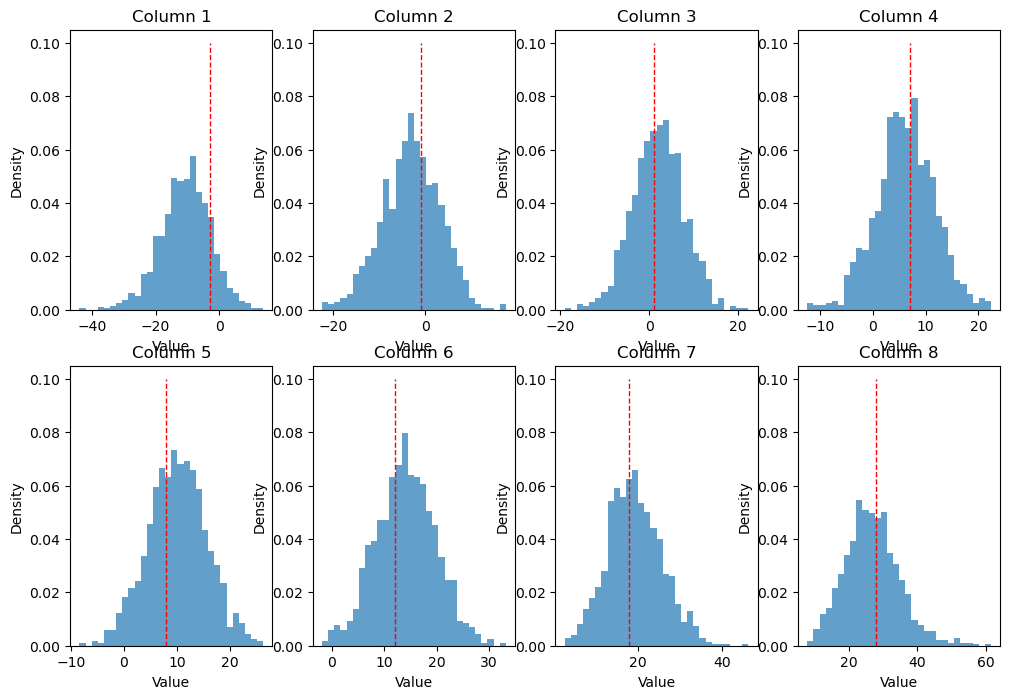

In [8]:
import numpy as np

schools_data = np.sort([28, 18, 12, 8, 7, 1, -1, -3])

rng = np.random.default_rng()
# get 8000 samples and reshape
samples = rng.normal(loc=8.0, scale=13.0, size=8000)
samples = samples.reshape((1000, 8))

# sort by columns 
sorted_samples = np.sort(samples, axis=1)

# plot histogram of each column
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for i in range(sorted_samples.shape[1]):
    plt.subplot(2, 4, i + 1)
    plt.hist(sorted_samples[:, i], bins=30, density=True, alpha=0.7)
    plt.title(f'Column {i + 1}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.vlines(x=schools_data[i],ymin = 0, ymax=.1, color='r', linestyle='dashed', linewidth=1, label='School Data')


Here the observed data order is quite consistent with the expected distribution of sorted values.  If the observed data in any case was outside the some prescribed interval of the simulated data, then we can might have reason to reject the model.    We could even combine this into a single test, calculating the fraction of simulated draws that are more extreme then the observed data in for every case.   

In [11]:
# compute fraction of samples more extreme in each case:
for i in range(sorted_samples.shape[1]):
    if np.mean(sorted_samples[:, i]) < schools_data[i]:
        more_extreme = np.sum(sorted_samples[:, i] >= schools_data[i]) / sorted_samples.shape[0]
    else:   
        more_extreme = np.sum(sorted_samples[:, i] <= schools_data[i]) / sorted_samples.shape[0]
    print(f'Column {i + 1}: {more_extreme:.4f} of samples are more extreme than school data {schools_data[i]}')

Column 1: 0.1610 of samples are more extreme than school data -3
Column 2: 0.3740 of samples are more extreme than school data -1
Column 3: 0.4280 of samples are more extreme than school data 1
Column 4: 0.4380 of samples are more extreme than school data 7
Column 5: 0.3590 of samples are more extreme than school data 8
Column 6: 0.3490 of samples are more extreme than school data 12
Column 7: 0.4350 of samples are more extreme than school data 18
Column 8: 0.4240 of samples are more extreme than school data 28


 b)  Even though the model fits under this test it is still unacceptable because many models might easily satisfy this test, for example if there is a predictor that is not included, a model whith smaller variance will work. Or if there is significant correlation, then a model with larger variance. 
 